In [1]:
import sys
sys.path.append('..')
from lib.method import LSB
from lib.utils import int2byte
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path


## 得到几张不同嵌入率的LSBR顺序嵌入图像，用来做卡方分析

In [2]:
# 读入灰度图像
lenna = cv2.imread("./lenna.png", cv2.IMREAD_GRAYSCALE).reshape(512, 512,1)
lenna_shape = lenna.shape
message_size = lenna_shape[0] * lenna_shape[1]
lsbr = LSB(message_size, lenna_shape)
# 生成随机消息
message_20 = b''.join([int2byte(i) for i in np.random.randint(0, 255, int(message_size*0.2//8))])
message_50 = b''.join([int2byte(i) for i in np.random.randint(0, 255, int(message_size*0.5//8))])
message_100 = b''.join([int2byte(i) for i in np.random.randint(0, 255, int(message_size//8-1))])
# 嵌入消息
lenna_20 = lsbr.encode(lenna.copy(), message_20, 0)
lenna_50 = lsbr.encode(lenna.copy(), message_50, 0)
lenna_100 = lsbr.encode(lenna.copy(), message_100, 0)

lenna_20_M = lsbr.encode(lenna.copy(), message_20, 0, True)
lenna_50_M = lsbr.encode(lenna.copy(), message_50, 0, True)
lenna_100_M = lsbr.encode(lenna.copy(), message_100, 0, True)


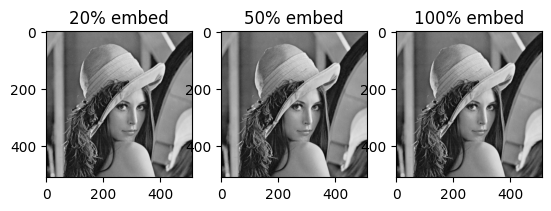

In [3]:
plt.subplot(1, 3, 1)
plt.imshow(lenna_20, cmap="gray")
plt.title("20% embed")

plt.subplot(1, 3, 2)
plt.imshow(lenna_50, cmap="gray")
plt.title("50% embed")
plt.subplot(1, 3, 3)
plt.imshow(lenna_100, cmap="gray")
plt.title("100% embed")
# save the embed image
plt.imsave("LSMR_lenna_20.png", lenna_20.reshape(512, 512))
plt.imsave("LSMR_lenna_50.png", lenna_50.reshape(512, 512))
plt.imsave("LSMR_lenna_100.png", lenna_100.reshape(512, 512))


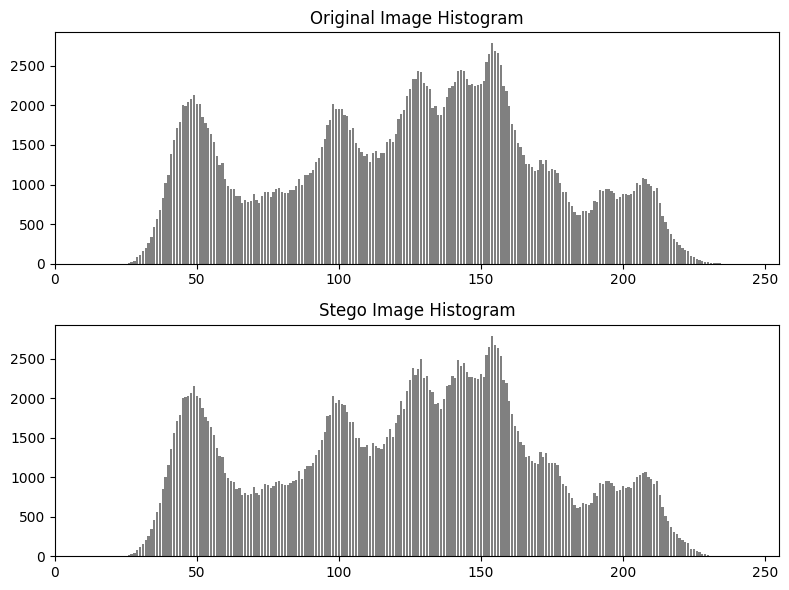

In [4]:
img_ori = lenna
img_steg_n1 = lenna_20
hist_ori = cv2.calcHist([img_ori], [0], None, [256], [0,256]).flatten()
hist_stego = cv2.calcHist([img_steg_n1], [0], None, [256], [0,256]).flatten()

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].bar(range(256), hist_ori, color='gray')
axs[0].set_title('Original Image Histogram')
axs[0].set_xlim([0, 255])

axs[1].bar(range(256), hist_stego, color='gray')
axs[1].set_title('Stego Image Histogram')
axs[1].set_xlim([0, 255])

plt.tight_layout()
plt.show()




In [5]:
from scipy.stats import chi2
def calc_chi_full(img):
    '''
    计算img的卡方检测值
    
    :param img: 传入numpy数组
    
    :return: (r, p) 卡方统计值和隐写的概率
    '''
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    # 遍历灰度值对，计算卡方值
    r, k = 0, 0
    for i in range(0, 256, 2):
        if i + 1 >= 256:
            break
        # 计算每对的像素总数
        pair_total = hist[i] + hist[i + 1]
        if pair_total == 0:
            continue  # 避免除以0

        # 计算并累加卡方值
        r += ((hist[i] - hist[i + 1]) ** 2) / pair_total / 2
        k += 1
    p = 1 - chi2.cdf(r, 127)
    return r, p    


In [6]:
print("LSBR")
print(f"the r and p of origin is {calc_chi_full(lenna)}")
print(f"the r and p of 20% embed is {calc_chi_full(lenna_20)}")
print(f"the r and p of 50% embed is {calc_chi_full(lenna_50)}")
print(f"the r and p of 100% embed is {calc_chi_full(lenna_100)}")
print("------------------------------------------------------\nLSBM")
print(f"the r and p of origin is {calc_chi_full(lenna)}")
print(f"the r and p of 20% embed is {calc_chi_full(lenna_20_M)}")
print(f"the r and p of 50% embed is {calc_chi_full(lenna_50_M)}")
print(f"the r and p of 100% embed is {calc_chi_full(lenna_100_M)}")

LSBR
the r and p of origin is (np.float32(185.51224), np.float64(0.0005503786599588834))
the r and p of 20% embed is (np.float32(143.40816), np.float64(0.15157944421409641))
the r and p of 50% embed is (np.float32(108.89652), np.float64(0.875443915629228))
the r and p of 100% embed is (np.float32(54.82489), np.float64(0.9999999972327221))
------------------------------------------------------
LSBM
the r and p of origin is (np.float32(185.51224), np.float64(0.0005503786599588834))
the r and p of 20% embed is (np.float32(176.49521), np.float64(0.0024367616572776862))
the r and p of 50% embed is (np.float32(167.63495), np.float64(0.009132192597000155))
the r and p of 100% embed is (np.float32(171.61874), np.float64(0.005133430097864489))


In [7]:
def calc_chi_blocks(img ) -> list:
# 遍历灰度值对，计算卡方值
    '''
    分别计算前10% , 20%, 30%  ... 100%的隐写概率
    
    :param img: 需要计算的图像
    :return: list曲线
    '''
    p_list = []
    for i in range(1, 11):
        img_tmp = img.flatten()
        img_tmp = img_tmp[:round(len(img_tmp)*i*0.1)]
        _, p = calc_chi_full(img_tmp)
        p_list.append(p)
        
    return p_list
        

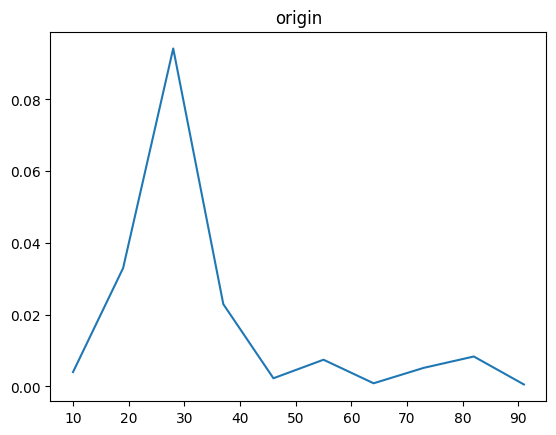

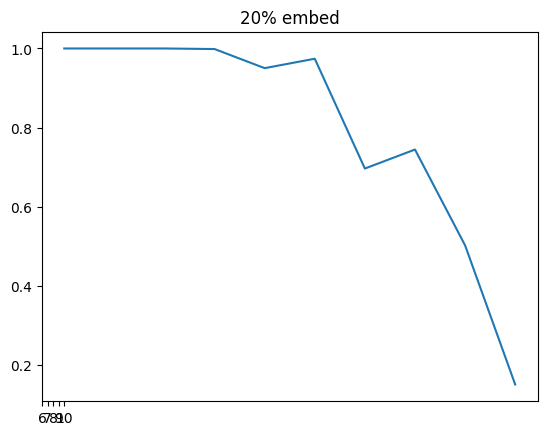

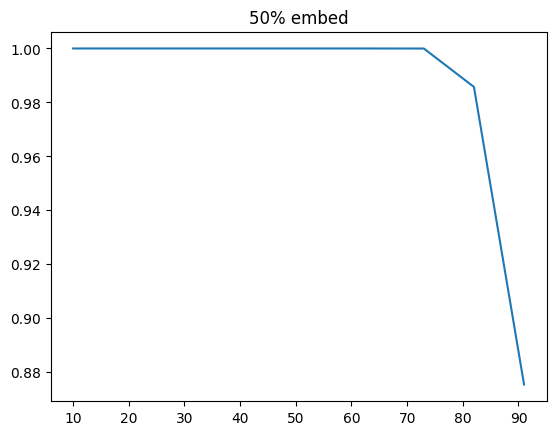

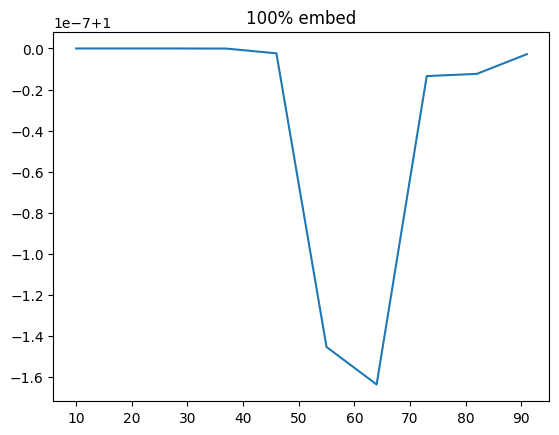

In [8]:
p_list = calc_chi_blocks(lenna)
x_values = [10 + (i * 90 / len(p_list)) for i in range(len(p_list))]
plt.plot(x_values, p_list)
plt.title("origin")

plt.show()
plt.xticks(range(1, 11))

p_list = calc_chi_blocks(lenna_20)
plt.plot(x_values, p_list)
plt.title("20% embed")
plt.show()


p_list = calc_chi_blocks(lenna_50)
plt.plot(x_values, p_list)
plt.title("50% embed")
plt.show()


p_list = calc_chi_blocks(lenna_100)
plt.plot(x_values, p_list)
plt.title("100% embed")
plt.show()

In [9]:

class Jsteg:
    '''
    Jsteg隐写与提取
    嵌入步骤  
    将载体图像分为8×8的块，做二维DCT变换,做系数量化
    判断AC系数是否等于0或±1，是则跳过，否则继续
    提取AC系数的LSB，嵌入秘密信息
    提取步骤  
    将载体图像分为8×8的块，做二维DCT变换
    判断AC系数是否等于0或±1 ，是则跳过，否则继续
    提取AC系数的LSB，提取秘密信息
    '''
    
    def __init__(self):
        self.quantization_matrix = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])
    
    
    def blkproc(self, image , block_size, fun, *args, **kwargs):
        # 获取图像的尺寸
        width, height = image.shape[0], image.shape[1]
        # 初始化结果数组
        result_array = np.zeros_like(image)
        # 遍历图像并应用函数到每个块
        for i in range(0, width, block_size[0]):
            for j in range(0, height, block_size[1]):
                # 提取块
                block = image[j:j+block_size[1], i:i+block_size[0]]
                # 应用函数
                processed_block = fun(block, *args, **kwargs)
                # 将处理后的块放回结果数组
                result_array[j:j+block_size[1], i:i+block_size[0]] = processed_block

        return result_array
    
    def encode(self, img, message):
        # 预处理
        message = message + b'\x00'
        message = "".join([format(x, '08b') for x in message])
        self.message_size = len(message)
        self.message_idx = 0
        print(message)
        # QDCT
        def QDCT(block):
            dct_block = cv2.dct(block.astype(np.float32))
            quantized_block = np.round(dct_block / self.quantization_matrix)
            return quantized_block
        # 分块 量化
        img = self.blkproc(img, (8, 8), QDCT)
        # 嵌入
        # 主要嵌入规则：
        # 跳过值为0和±1的AC系数
        # 如果要嵌入1且系数是偶数，将系数±1使其变为奇数
        # 如果要嵌入0且系数是奇数，将系数±1使其变为偶数
        # 修改时保持系数的正负号不变
        def hidden_block(block, message):
            block = block.flatten()
            for idx, x in enumerate(block):
                if self.message_idx >= self.message_size:
                    return block.reshape(8, 8)
                if x == 0 or x == -1 or x == 1:
                    continue
                elif abs(x) % 2 == 0 and message[self.message_idx] == '1':
                    block[idx] = x - 1 if x < 0 else x + 1
                elif abs(x) % 2 == 1 and message[self.message_idx] == '0':
                    block[idx] = x + 1 if x < 0 else x - 1 
                self.message_idx += 1
            return block.reshape(8, 8)
        img = self.blkproc(img, (8, 8), hidden_block, message)
        self.message_size = 0
        self.message_idx = 0
        global bug1 
        bug1 = img
        img = self.blkproc(img, (8, 8), cv2.idct)
        return img
    
    def decode(self,img):
        data = img.copy()
        data = self.blkproc(data, (8, 8), cv2.dct)
        data = np.round(data)
        global bug2
        bug2 = data
        message = []
        def get_block(block, message):
            block = block.flatten().astype(int)
            for idx, x in enumerate(block):
                if x == 0 or x == -1 or x == 1:
                    continue
                if x & 1 == 1:
                    message.append('1')
                else:
                    message.append('0')
            return block.reshape(8, 8)
        
        img = self.blkproc(data, (8, 8), get_block, message)
        message = "".join(message)
        message = [message[i:i+8] for i in range(0, len(message), 8)]
        message = [int(x, 2) for x in message]
        message = bytes(message)
        end = message.find(b'\x00')
        message = message[:end]
        return message 

lenna

In [10]:
# lenna必须是浮点类型
lenna = lenna.reshape(512, 512).astype(np.float32)
jsteg = Jsteg()
message = b'Hello World!'
hidden_image = jsteg.encode(lenna, message)
new_message = jsteg.decode(hidden_image)
new_message

01001000011001010110110001101100011011110010000001010111011011110111001001101100011001000010000100000000


b'Hello World!'